## Linear Regression

### Added snippet used as a reference for all models

This model is based on the TuringTutorial example [LinearRegression](https://github.com/TuringLang/TuringTutorials/blob/csp/linear/LinearRegression.ipynb) by Cameron Pfiffer.

Turing is powerful when applied to complex hierarchical models, but it can also be put to task at common statistical procedures, like linear regression. This tutorial covers how to implement a linear regression model in Turing.

We begin by importing all the necessary libraries.

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, GLM
gr(size=(500,500))

ProjDir = rel_path("..", "scripts", "00")
cd(ProjDir)

Import the dataset.

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [3]:
data = filter(row -> row[:age] >= 18, df)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Show the first six rows of the dataset.

In [4]:
first(data, 6)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1


The next step is to get our data ready for testing. We'll split the mtcars dataset into two subsets, one for training our model and one for evaluating our model. Then, we separate the labels we want to learn (MPG, in this case) and standardize the datasets by subtracting each column's means and dividing by the standard deviation of that column.

The resulting data is not very familiar looking, but this standardization process helps the sampler converge far easier. We also create a function called unstandardize, which returns the standardized values to their original form. We will use this function later on when we make predictions.

Split our dataset 70%/30% into training/test sets.

In [5]:
n = size(data, 1)
test_ind = sample(1:n, Int(floor(0.3*n)), replace=false);
train_ind = [(i) for i=1:n if !(i in test_ind)];
test = data[test_ind, :];
train = data[train_ind, :];

Save dataframe versions of our dataset.

In [6]:
train_cut = DataFrame(train)
test_cut = DataFrame(test)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,146.05,37.5064,24.0,0
2,160.655,54.0908,26.0,1
3,160.02,37.0811,75.9,1
4,153.67,44.2252,26.0,0
5,144.145,39.4342,34.0,0
6,166.37,52.6734,43.0,1
7,156.21,54.0625,21.0,0
8,139.7,50.3487,38.0,1
9,145.415,42.1274,29.0,0


Create our labels. These are the values we are trying to predict.

In [7]:
train_label = train[:, :height]
test_label = test[:, :height]

105-element Array{Union{Missing, Float64},1}:
 146.05 
 160.655
 160.02 
 153.67 
 144.145
 166.37 
 156.21 
 139.7  
 145.415
 161.925
   ⋮    
 158.75 
 154.305
 145.415
 162.56 
 171.45 
 156.845
 152.4  
 161.925
 149.86 

Get the list of columns to keep.

In [8]:
remove_names = filter(x->!in(x, [:height, :age, :male]), names(data))

1-element Array{Symbol,1}:
 :weight

Filter the test and train sets.

In [9]:
train = Matrix(train[:, remove_names]);
test = Matrix(test[:, remove_names]);

A handy helper function to rescale our dataset.

In [10]:
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

standardize (generic function with 1 method)

Another helper function to unstandardize our datasets.

In [11]:
function unstandardize(x, orig)
    return x .* std(orig, dims=1) .+ mean(orig, dims=1)
end

unstandardize (generic function with 1 method)

Standardize our dataset.

In [12]:
(train, train_orig) = standardize(train)
(test, test_orig) = standardize(test)
(train_label, train_l_orig) = standardize(train_label)
(test_label, test_l_orig) = standardize(test_label);

Design matrix

In [13]:
dmat = [ones(size(train, 1)) train]

247×2 Array{Float64,2}:
 1.0   0.463908
 1.0  -1.2832  
 1.0  -1.99515 
 1.0   1.26758 
 1.0  -0.545047
 1.0   2.80066 
 1.0   1.64321 
 1.0  -1.53216 
 1.0   1.49033 
 1.0  -0.553783
 ⋮             
 1.0  -0.309188
 1.0  -0.10827 
 1.0  -0.121374
 1.0   0.472643
 1.0  -0.83332 
 1.0  -0.579989
 1.0   0.34161 
 1.0  -1.62825 
 1.0   1.13218 

Bayesian linear regression.

In [14]:
lrmodel = "
data {
  int N; //the number of observations
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008

  y ~ normal(linpred,sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [15]:
stanmodel = Stanmodel(name="linear_regression",
  monitors = ["beta.1", "beta.2", "sigma"],
  model=lrmodel);
# Input data for cmdstan
lrdata = Dict("N" => size(train, 1), "K" => size(dmat, 2), "y" => train_label, "X" => dmat);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/00/tmp/linear_regression.stan will be updated.



Sample using cmdstan

In [16]:
rc, sim, cnames = stan(stanmodel, lrdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Convert to a MCMCChain Chain object
cnames = ["intercept", "beta[1]", "sigma"]
chain = convert_a3d(sim, cnames, Val(:mcmcchain))

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -24.6802, but must be > 0!  (in '/Users/rob/.julia/dev/StatisticalRethinking/scripts/00/tmp/linear_regression.stan' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -26.728, but must be > 0!  (in '/Users/rob/.julia/dev/StatisticalRethinking/scripts/00/tmp/linear_regression.stan' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be eit

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[0.0188102 0.726594 0.652941; 0.0842762 0.784247 0.632817; … ; -0.0136308 0.732681 0.648942; 0.0146264 0.783682 0.652421]

Union{Missing, Float64}[-0.0263522 0.755825 0.664391; 0.0215814 0.758038 0.623605; … ; 0.00941482 0.760998 0.672133; 0.000137656 0.750147 0.661081]

Union{Missing, Float64}[-0.0339943 0.748128 0.647733; 0.0280585 0.796098 0.660291; … ; 0.0479773 0.762973 0.677428; 0.0224946 0.814657 0.65806]

Union{Missing, Float64}[-0.0262977 0.727206 0.624499; 0.0326895 0.798015 0.679622; … ; 0.0360094 0.806445 0.592811; 0.035721 0.749739 0.654277]

Describe the chains.

In [17]:
describe(chain)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
              Mean          SD        Naive SE       MCSE      ESS
intercept 0.0018102046 0.041589309 0.00065758471 0.0007825265 1000
  beta[1] 0.7587711405 0.042134167 0.00066619968 0.0007209498 1000
    sigma 0.6556443463 0.029437054 0.00046544069 0.0005030979 1000

Quantiles:
              2.5%       25.0%       50.0%       75.0%      97.5%  
intercept -0.07843231 -0.02658435 0.001395315 0.02859015 0.08675716
  beta[1]  0.67593720  0.73093475 0.758539500 0.78697300 0.84078585
    sigma  0.60168013  0.63576375 0.654491000 0.67446100 0.71897948



Perform multivariate OLS.

In [18]:
ols = lm(@formula(height ~ weight), train_cut)

StatsModels.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: height ~ 1 + weight

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)   113.801   2.23438 50.9319   <1e-99
weight       0.900926 0.0493455 18.2575   <1e-46


Store our predictions in the original dataframe.

In [19]:
train_cut.OLSPrediction = predict(ols);
test_cut.OLSPrediction = predict(ols, test_cut);

Make a prediction given an input vector.

In [20]:
function prediction(chain, x)
    α = chain[:, 1, :].value
    β = [chain[:, i, :].value for i in 2:2]
    return  mean(α) .+ x * mean.(β)
end

prediction (generic function with 1 method)

Calculate the predictions for the training and testing sets.

In [21]:
train_cut.BayesPredictions = unstandardize(prediction(chain, train), train_l_orig);
test_cut.BayesPredictions = unstandardize(prediction(chain, test), test_l_orig);

Show the first side rows of the modified dataframe.

In [22]:
remove_names = filter(x->!in(x, [:age, :male]), names(test_cut));
test_cut = test_cut[remove_names];
first(test_cut, 6)

bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.height).^2);
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.height).^2);

bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.height).^2);
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.height).^2);

println("\nTraining set:")
println("  Bayes loss: $bayes_loss1")
println("  OLS loss: $ols_loss1")

println("Test set:")
println("  Bayes loss: $bayes_loss2")
println("  OLS loss: $ols_loss2")


Training set:
  Bayes loss: 6182.604660713937
  OLS loss: 6182.554068179008
Test set:
  Bayes loss: 2816.621278659707
  OLS loss: 2896.7940317478865


Plot the chains.

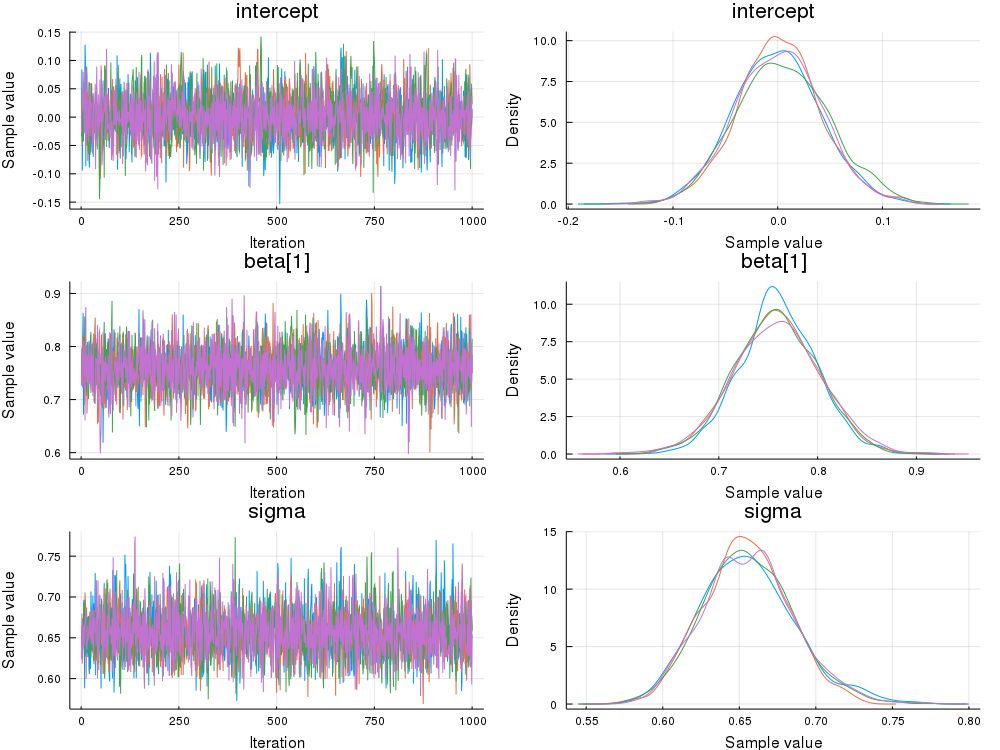

In [23]:
plot(chain)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*